In [80]:
import numpy as np
import matplotlib.pyplot as plt
import gdal
import cv2

gdal.AllRegister()

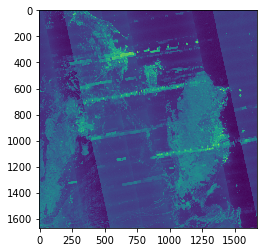

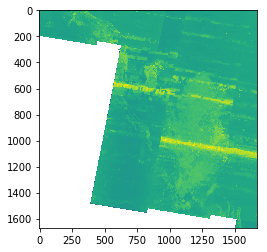

In [81]:
ds = gdal.Open('./vhExport.tif')

vh_band = ds.GetRasterBand(1)
vh = vh_band.ReadAsArray()
plt.imshow(vh)
plt.show()

vv_band = ds.GetRasterBand(2)
vv = vv_band.ReadAsArray()
plt.imshow(vv)
plt.show()

# Handle NaN values (places where there's no data) by setting them to be
# moderately small backscatter values
vh[np.isnan(vh)]=np.median(vh[np.isfinite(vh)]) - np.std(vh[np.isfinite(vh)])
vv[np.isnan(vv)]=np.median(vv[np.isfinite(vv)]) - np.std(vv[np.isfinite(vv)])

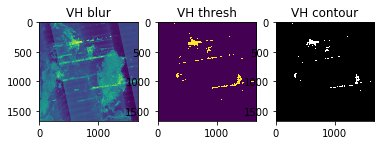

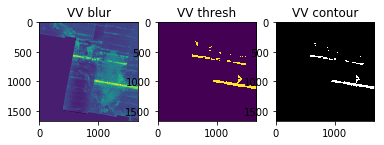

In [115]:
def processing_chain(raw, polarization_name, blur_val=15, thresh_val=110):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    # Force the scalar field to [0, 255]
    shifted = raw - np.min(raw)
    scaled = shifted / np.max(shifted) * 255
    scaled = scaled.astype(np.uint8)
    
    # Trick OpenCV into believing that this array is an image
    img = np.zeros([scaled.shape[0],scaled.shape[1],3])
    img[:,:,0] = scaled
    img[:,:,1] = scaled
    img[:,:,2] = scaled
    r,g,b = cv2.split(img)
    bgr = cv2.merge([b,g,r])
    bgr = bgr.astype(np.uint8)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    
    # Blur
    blured = cv2.blur(gray,(blur_val, blur_val))
    ax1.imshow(blured)
    ax1.set_title(polarization_name + ' blur')
    
    # Threshold
    thresh_val = np.mean(blured) + thresh_val * np.std(blured)
    (ret, thresh) = cv2.threshold(blured, thresh_val, 1, 0)
    ax2.imshow(thresh)
    ax2.set_title(polarization_name + ' thresh')
    
    # Get contours
    im, contours, hier = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(thresh, contours, -1, (0,255,0), 3)
    ax3.imshow(thresh,cmap='gray')
    ax3.set_title(polarization_name + ' contour')
    plt.show()
    
    return thresh

vht = processing_chain(vh, 'VH', thresh_val=2.5)
vvt = processing_chain(vv, 'VV', thresh_val=2.5)

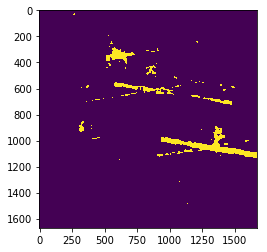

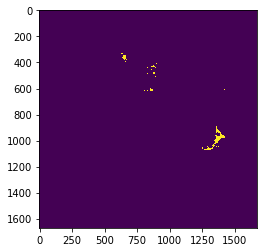

In [116]:
intersection = np.logical_and(vht, vvt)
union = np.logical_or(vht, vvt)

plt.imshow(union)
plt.show()

plt.imshow(intersection)
plt.show()